# API总体演示

这里将演示：
1. 初始化过程
2. 图像通路和图像处理
3. Arduino microblaze API

颜色检测和HDMI输出在3.color_tracing.ipynb中演示

## 导入库文件并对PL编程

In [1]:
import numpy as np
from PYNQ_Car.CarOverlay.CarOverlay import CarOverlay
from pynq.overlay import Overlay 
from PIL import Image
import IPython
from PYNQ_Car.Infra.camera import Camera
from PYNQ_Car.Infra.MotionController import MotionController
from PYNQ_Car.Infra.rangefinder import rangefinder
from PYNQ_Car.Infra.IMU import IMU
overlay = CarOverlay('/usr/local/lib/python3.6/dist-packages/PYNQ_Car/Overlay/Car.bit')

## 初始化各个实例

### 实例化对象

驱动中提供规定的接口，就可以将驱动注册至API类里面,图像处理类没有提供统一的API.

In [2]:
OV5640 = Camera(overlay.OV5640)
video_proc = overlay.video_proc
mc = MotionController(overlay.Arduino)
IMU = IMU(overlay.Arduino)
rangefinder = rangefinder(overlay.Arduino)

## 图像通路和图像处理模块的使用

### 编写在notebook上显示图像的函数

In [3]:
def imshow_rgba(frame):
    image = Image.fromarray(frame)
    r, g, b = image.split()
    image = Image.merge('RGB', [r,g,b])
    IPython.display.clear_output(1)
    display(image)
def imshow_gray(frame):
    image = Image.fromarray(frame)
    IPython.display.clear_output(1)
    display(image)

### 从OV5640摄像头读入RGB图，分辨率1280×720

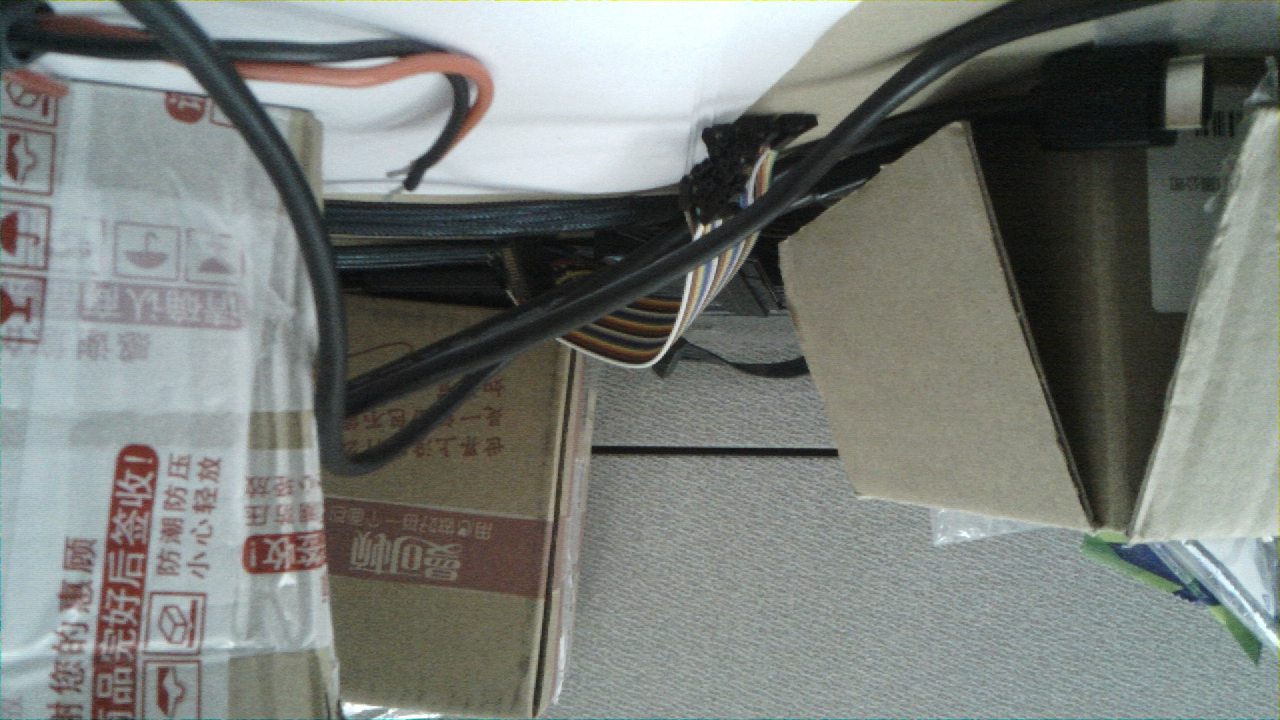

In [4]:
frame = OV5640.get_frame('RGB')
imshow_rgba(frame)
frame.freebuffer()

### 从OV5640摄像头读入灰度图，分辨率1280×720

注意，这里图片尺寸是1280×720×1

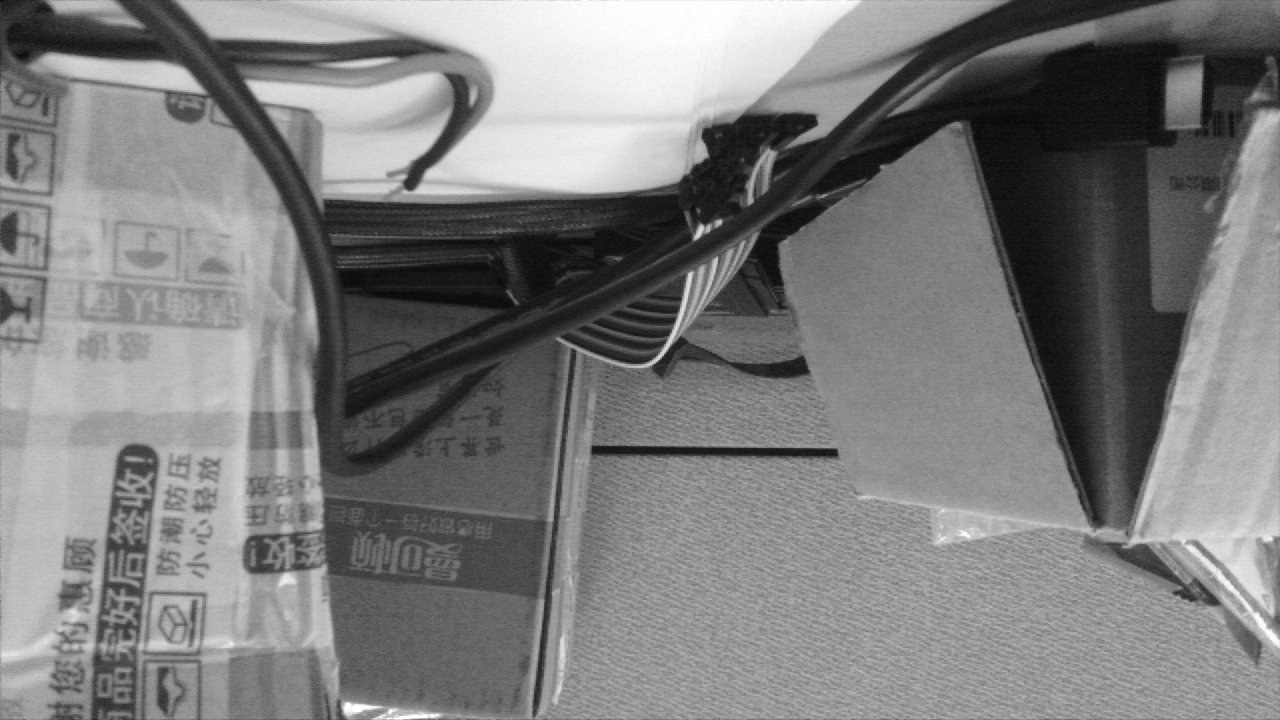

In [5]:
frame = overlay.OV5640.get_frame('gray')
imshow_gray(frame)
frame.freebuffer()

### 测试图像处理通路是否正常

注意，这里不对图像做任何处理

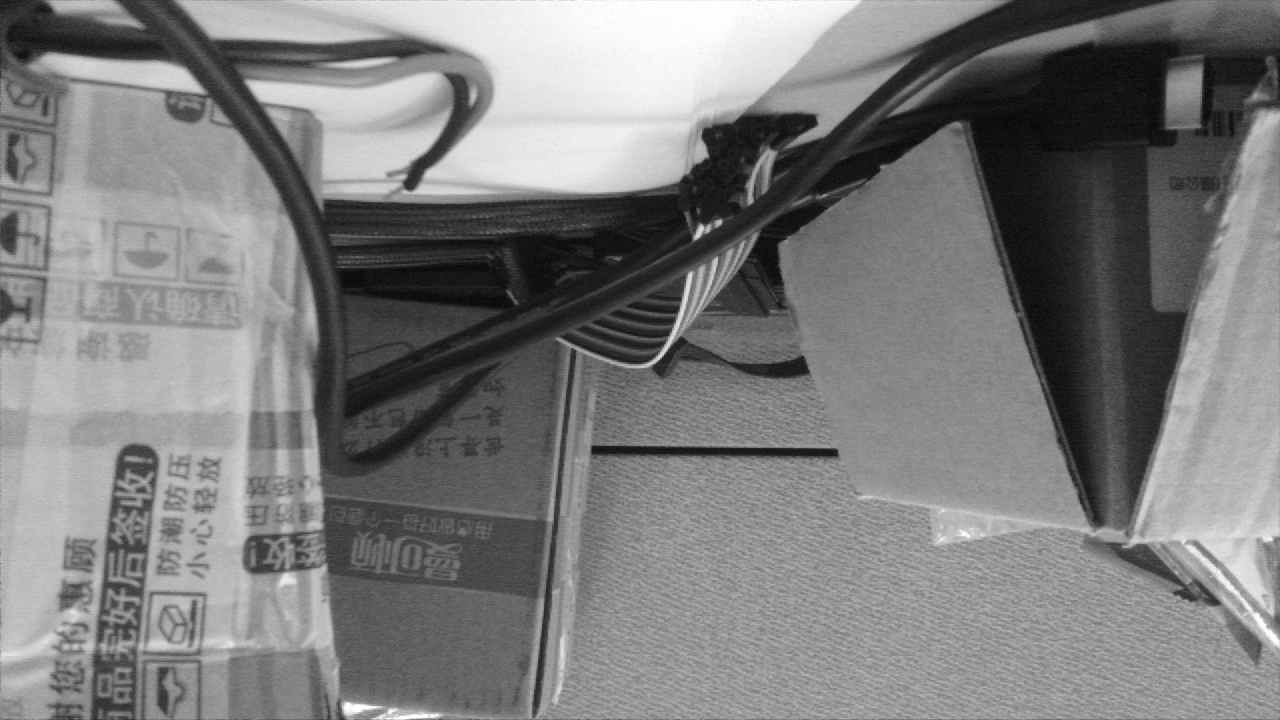

In [6]:
frame = OV5640.get_frame('gray')
res = video_proc.Bypass(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### X方向Sobel滤波

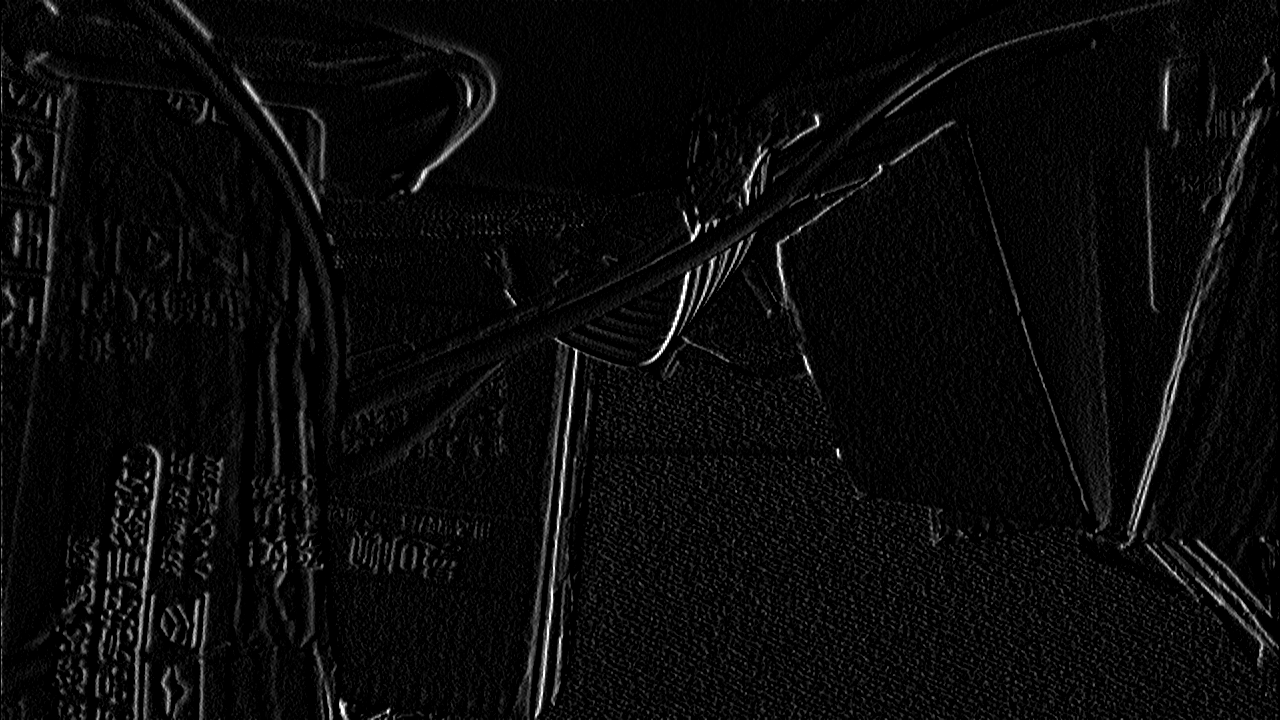

In [7]:
frame = OV5640.get_frame('gray')
res = video_proc.SobelX(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### Y方向Sobel滤波

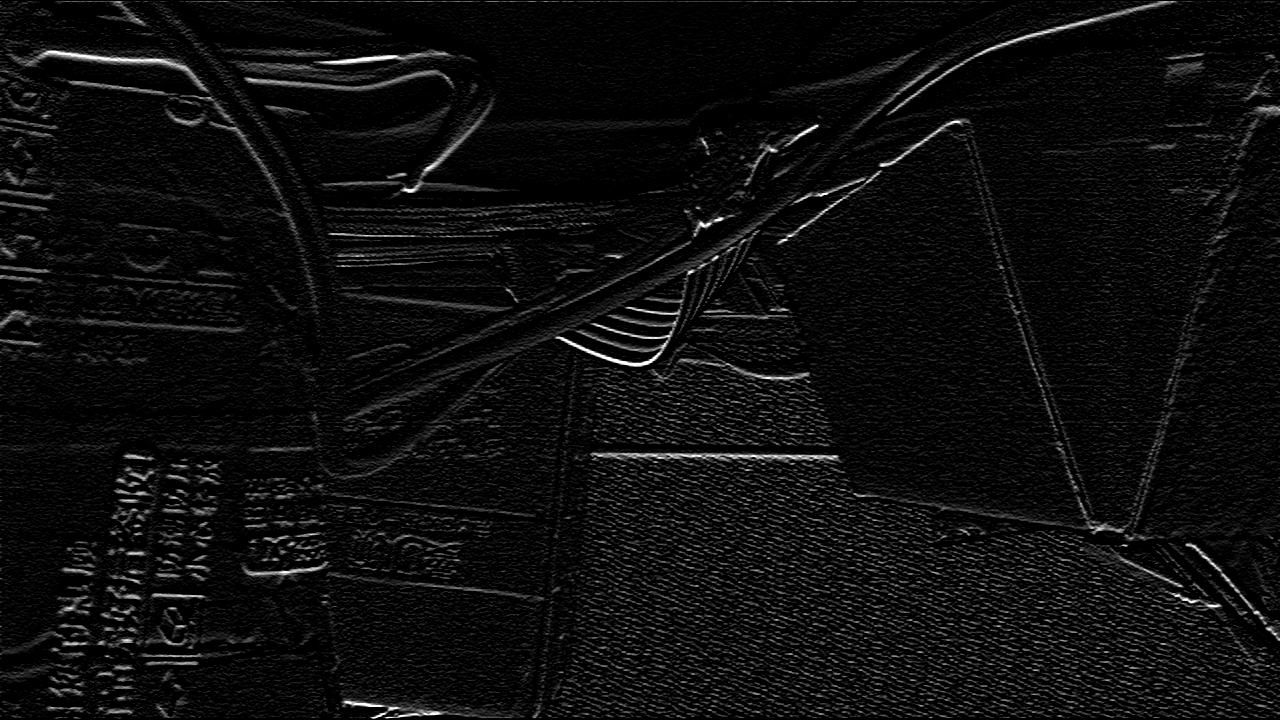

In [8]:
frame = OV5640.get_frame('gray')
res = video_proc.SobelY(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### Canny算子

强边缘亮度值为255，弱边缘亮度值为127，非边缘亮度值为0

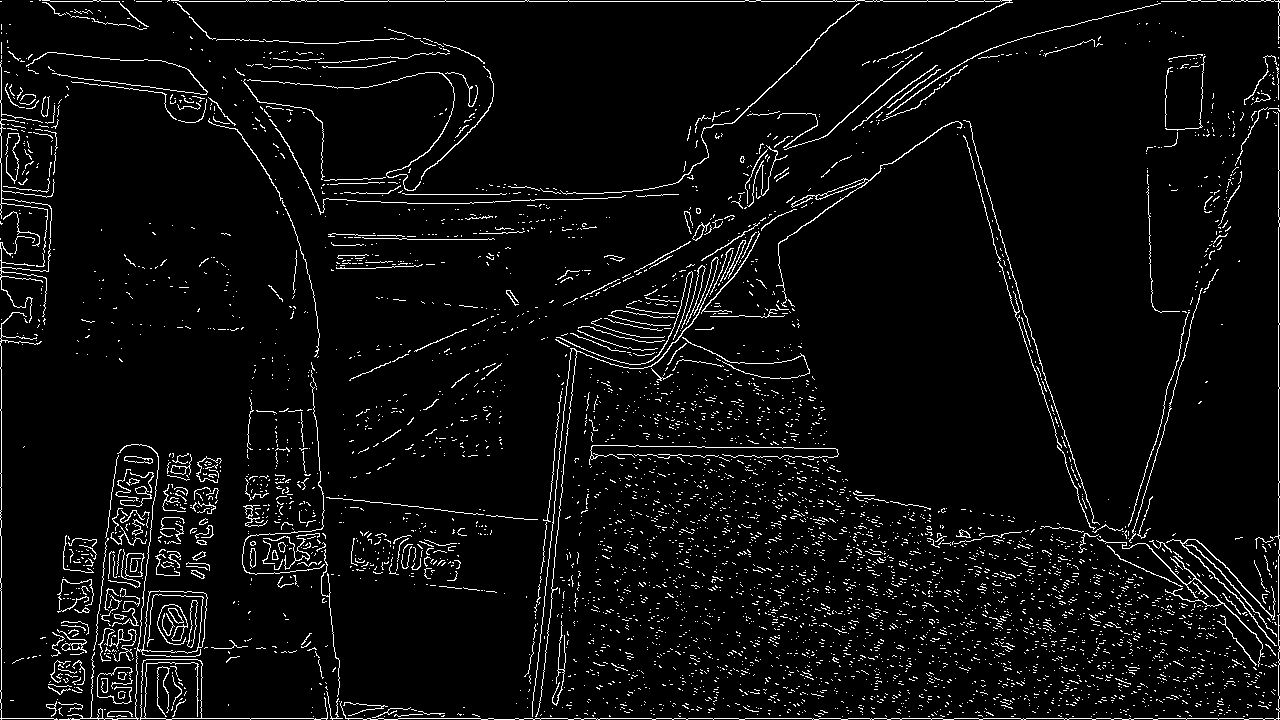

In [9]:
frame = OV5640.get_frame('gray')
res = video_proc.Canny(frame,60,80)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

## Arduino microblaze API演示

### IMU API演示

In [10]:
%%timeit -n 100
ax,ay,az = IMU.get_accl()

100 loops, best of 3: 3.66 ms per loop


In [11]:
%%timeit -n 100
gx,gy,gz = IMU.get_gyro()

100 loops, best of 3: 3.7 ms per loop


In [12]:
%%timeit -n 100
cx,cy,cz = IMU.get_compass()

100 loops, best of 3: 3.62 ms per loop


### 运动控制API演示

#### 舵机角度控制

In [13]:
mc.set_direction(-45)

In [14]:
mc.set_direction(45)

In [15]:
mc.set_direction(0)

#### 电机速度控制

In [16]:
mc.set_velocity(500)

In [17]:
mc.set_velocity(-500)

In [18]:
mc.set_velocity(0)

#### 超声波测距模块数据读取（单位：cm）

In [19]:
import time
count = 50
while(count > 0):
    print(rangefinder.get_range_cm())
    count = count - 1
    time.sleep(0.3)

17.29310344827586
17.29310344827586
17.310344827586206
17.310344827586206
17.310344827586206
17.310344827586206
17.310344827586206
17.310344827586206
17.310344827586206
16.948275862068964
15.637931034482758
17.448275862068964
14.89655172413793
19.120689655172413
19.724137931034484
20.137931034482758
24.982758620689655
18.46551724137931
18.46551724137931
24.5
17.96551724137931
18.155172413793103
14.258620689655173
11.53448275862069
14.327586206896552
14.775862068965518
14.775862068965518
14.793103448275861
14.793103448275861
14.413793103448276
14.39655172413793
14.39655172413793
14.413793103448276
14.39655172413793
14.431034482758621
15.327586206896552
19.17241379310345
20.03448275862069
16.0
16.0
15.60344827586207
15.60344827586207
15.60344827586207
15.189655172413794
15.189655172413794
18.689655172413794
16.46551724137931
5.741379310344827
5.879310344827586
6.224137931034483


## 结束，务必将图像通路关闭

In [21]:
OV5640.stop()
video_proc.stop()